# 便利機能
- utils
- feature_selection
- StandardScaler

下ごしらえ

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import load_breast_cancer
breast=load_breast_cancer()
data=breast.data
target=breast.target
feature_name=breast.feature_names

dataをposiとnegaに分割しておく

In [3]:
malignant=data[target==0]
benign=data[target==1]

# 今回のお題

In [4]:
from sklearn import utils
from sklearn import feature_selection as fs
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

## 便利機能その1
- resample

breast_cancerのposiとnegaの比率を見てみると...

In [5]:
for i,j in enumerate(breast.target_names):
    print("{}: {}".format(j,len(target[target==i])))
# 良性の患者がちょっと多め

malignant: 212
benign: 357


posiとnegaからそれぞれresampleする

In [6]:
malignant_resample=utils.resample(malignant,n_samples=200)
benign_resample=utils.resample(benign,n_samples=200)

In [7]:
print(benign_resample.shape)
print(malignant_resample.shape)

(200, 30)
(200, 30)


使うときはresampleした結果をmergeする（列方向に結合）

In [8]:
# np.r_で列方向に結合できる。
data_resample=np.r_[malignant_resample,benign_resample]
target_resample=np.r_[[0 for i in range(200)],[1 for i in range(200)]]

In [9]:
print(data_resample.shape)
print(target_resample.shape)

(400, 30)
(400,)


## 便利機能その２
- shuffle

In [10]:
data_shuffle, target_shuffle = utils.shuffle(data_resample, target_resample)

In [11]:
target_shuffle[0:10]

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1])

関数を一個にまとめておかないとseedが変わってしまい、バラバラになってしまうので注意。

## 便利機能その3
- SelectKBest
- SelectPercentile 

使い方はsklearnの基本と一緒。  
インスタンスを作って、fitして、(predictの代わりに)transformする。

In [12]:
selector=fs.SelectKBest(fs.chi2,k=3)
selector.fit(data,target)
pd.DataFrame(selector.transform(data)).head()

,0,1,2
0,1001.0,153.40,2019.0
1,1326.0,74.08,1956.0
2,1203.0,94.03,1709.0
3,386.1,27.23,567.7
4,1297.0,94.44,1575.0


単変量解析して、重要な特徴量を抽出する。  
特徴量のスコアリングは下記が使える
- 回帰: f_regression, mutual_info_regression
- 分類: chi2, f_classif, mutual_info_classif

scores_に各特徴料のスコアも入っている。  
でもちょいと特徴量名をとってくるのはちょいと面倒。

In [13]:
selector.scores_

array([  2.66104917e+02,   9.38975081e+01,   2.01110286e+03,
         5.39916559e+04,   1.49899264e-01,   5.40307549e+00,
         1.97123536e+01,   1.05440354e+01,   2.57379775e-01,
         7.43065536e-05,   3.46752472e+01,   9.79353970e-03,
         2.50571896e+02,   8.75850471e+03,   3.26620664e-03,
         6.13785332e-01,   1.04471761e+00,   3.05231563e-01,
         8.03633831e-05,   6.37136566e-03,   4.91689157e+02,
         1.74449400e+02,   3.66503542e+03,   1.12598432e+05,
         3.97365694e-01,   1.93149220e+01,   3.95169151e+01,
         1.34854195e+01,   1.29886140e+00,   2.31522407e-01])

In [14]:
feature_name[selector.scores_>sorted(selector.scores_,reverse=True)[3]]

array(['mean area', 'area error', 'worst area'], 
      dtype='<U23')

percentileを使えば、K個ではなくK％の特徴量を選択できる。

## 便利?機能その４
- VarianceThreshold

VarianceThresholdは分散が0のfeatureを除去できる。

In [15]:
df=pd.DataFrame([[0,1,0,1],[0,1,1,0],[0,1,0,0]],columns=["a","b","c","d"])
# こんな感じのデータがあるとすると...
df

,a,b,c,d
0,0,1,0,1
1,0,1,1,0
2,0,1,0,0


In [16]:
pd.DataFrame(fs.VarianceThreshold().fit_transform(df))

,0,1
0,0,1
1,1,0
2,0,0


カラム名を取ってくるのが超面倒。  
こちらに至ってはpandasでワンライナーなので、
pandasでやった方がわかりやすいと思う。

In [17]:
df.loc[:,df.var()!=0]

,c,d
0,0,1
1,1,0
2,0,0


feature selectionは話すと長いので基本的なとこまで。  
これ以上はドキュメントを参照してください。  
（RFEなんかもあります。）  
http://scikit-learn.org/dev/modules/feature_selection.html

# 便利機能その5 joblib.dump/load
joblib自体が便利です。  
http://postd.cc/my-top-5-new-python-modules-of-2015/  
http://blog.kzfmix.com/entry/1460182592  

joblibのdumpとloadは、pickleよりも効率的に永続化できるらしいので、sklearnではモデルのsave/loadはこれを使う。

In [18]:
joblib.dump(selector, 'selector.pkl', compress=True) 
selector_2 = joblib.load('selector.pkl')

In [19]:
selector_2

SelectKBest(k=3, score_func=<function chi2 at 0x7fc4a072c158>)

# 便利機能その6 StandardScaler

preprocessもきりがないので、一番簡単なのだけ

In [20]:
data_st=StandardScaler().fit_transform(data)

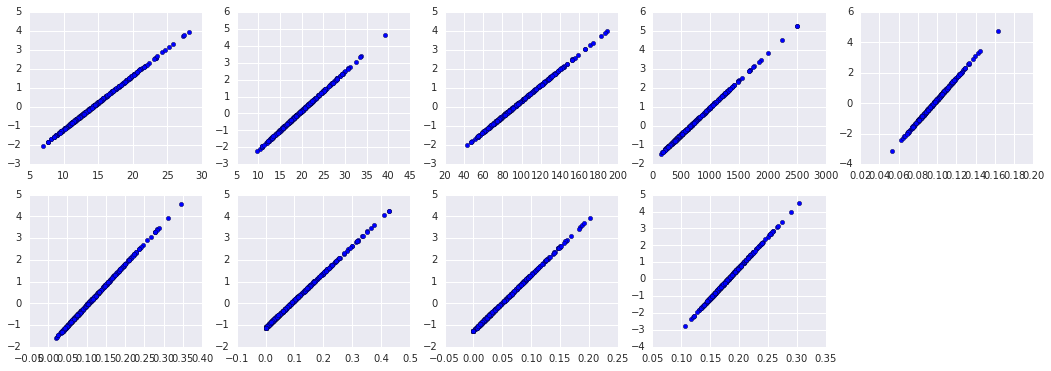

In [21]:
plt.figure(figsize=(18, 6))
for i in range(1,10):
    plt.subplot(250+i)
    plt.scatter(data[:,i-1],data_st[:,i-1])

# おしまい
@y__sama